In [1]:
# Not sure if we need all of this...
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import random_split

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy import spatial
from random import sample
import copy
import re
import nltk
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Import encoding dictionaries. i.e. bert_dict['cat'] = [0.5, -.4, 0.001,...]
bert_dict = np.load('bert.npy', allow_pickle = True); bert_dict = bert_dict[()]
glove_dict = np.load('glove.npy', allow_pickle = True); glove_dict = glove_dict[()]

# Part of speech tagging (already done on GloVe embeddings)
bert_dict_copy = bert_dict.copy()

for key in bert_dict_copy:  
    tag = nltk.pos_tag([key.strip()])[0][1]
    if tag not in ['NN', 'NNP']: 
        del bert_dict[key]

# Turn BERT into indexable embeddings
all_bert_words = list(bert_dict.keys())
word_to_idx = dict(zip(all_bert_words, range(len(all_bert_words))))
idx_to_word = dict(zip(range(len(all_bert_words)), all_bert_words))

# Get BERT embeddings as giant matrix
bert_embedding = [bert_dict[word] for word in all_bert_words]
bert_embedding = np.vstack(bert_embedding) # shape = (30000, 768)

In [3]:
# Read data from txt file
def read_data(examples, data): 
    '''
    Takes in dataset from examples and data (make sure they're for the same data!!!) and appends each example to
    a matrix. 
    For example, 
        board = 'cat', 'dog' (from examples)
        gold_word = 'pet' (from data)
    Will be appended as: 
        [[word_to_idx['cat], word_to_idx['dog']], [word_to_idx['dog']]]
    '''
    data_matrix = []
    with open(examples) as examples, open(data) as data:
        for line1, line2 in zip(examples, data):
            input_line_1 = line1.split('.')
            good_words = input_line_1[1].strip('\n').split(',')[:2]
            
            input_line_2 = line2.split('.')
            gold_word = input_line_2[1].strip()
            
            if input_line_1[0] == input_line_2[0]: 
                board = [word_to_idx[word.strip()] for word in good_words]
                if gold_word == 'No good clues': 
                    continue
            
                try: 
                    data_matrix.append([board, [word_to_idx[gold_word]]])
                except: 
                    continue
            else: 
                print(input_line_1[0])
                print(input_line_2[0])
                print('Uh oh, misaligment!')
                break
            
    return data_matrix

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size):
        super(NeuralNetwork, self).__init__()
        
        # Layer 1
        self.neural_network_1 = nn.Linear(2304, hidden_size)
        
        # Layer 2
        self.neural_network_2 = nn.Linear(hidden_size, 1)
        
        # Tanh
        self.tanh = nn.Tanh()

    # x is of size V x 1536 
    def forward(self, x):  
        # First layer
        s = self.neural_network_1(x)
        
        # First Tanh
        s = self.tanh(s)
        
        # Second layer
        s = self.neural_network_2(s)
        
        return s
    
    # Accuracy
    def accuracy(out, labels):
        outputs = np.argmax(out, axis=1)
        return np.sum(outputs==labels)/float(labels.size)

def loss_function(p_dist, gold_word):
    return torch.nn.CrossEntropyLoss()(p_dist, gold_word)

In [5]:
def train(model, train_data, optimizer, loss_function, params): 
    epochs = params['num_epochs']
    embedding = params['embedding']
    
    embedding_pt = torch.tensor(embedding, requires_grad=False)
    V, K = embedding.shape
    
    all_loss = []
    
    for epoch in range(epochs): 
        print('Epoch: {}'.format(epoch))
        
        # Set model to train
        model.train()
        
        # Initialize loss
        loss = 0
        
        for example in train_data:
            board, gold_word = example
            
            board_pt = torch.tensor(board, requires_grad=False)
            gold_word_pt = torch.tensor(gold_word, requires_grad=False)
    
            board_embedding_pt = embedding_pt[board_pt].view(1, 2 * K) # 2 x 768
            board_embedding_big = board_embedding_pt.expand(V, 2 * K) # V x (2 X 768)
            
            # Add embedding for each vocab word to board_embedding_big
            all_input = torch.cat([embedding_pt, board_embedding_big], dim=1) # (V x 1536)
            
            output = model(all_input)
            output_T = torch.transpose(output, 0, 1)
            
            loss += loss_function(output_T, gold_word_pt)
        
        all_loss.append(loss)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Backprop
        loss.backward()
        
        # Perform update using 
        optimizer.step()
    
    plt.plot(all_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    

In [22]:
def evaluate(model, val_data, loss_fn, params, idx_to_word): 
    # This function takes in a model, validation training set, loss function, and params
    # And will return the fraction of examples where
    # The truth clue (i.e. human chosen) is within the top 10 that the model spits out
    
    model.eval() #Set model to evaluation mode

    count = 0
    
    embedding_pt = torch.tensor(params['embedding'], requires_grad=False)

    V, K = params['embedding'].shape #(27296, 768)
    
    for example in val_data: 
        board, gold_word = example; #board = [X, Y], gold_word = [Z]
           
        board_pt = torch.tensor(board, requires_grad=False) #tensorfy the board, and say its not a variable that can be updated with backprop

        board_embedding_pt = embedding_pt[board_pt].view(1, 2 * K) # torch.Size([1, 1536])
        board_embedding_big = board_embedding_pt.expand(V, 2 * K) # torch.Size([27296, 1536])

        # Add embedding for each vocab word to board_embedding_big
        all_input = torch.cat([embedding_pt, board_embedding_big], dim=1) # torch.Size([27296, 2304])
        
        output = model(all_input) #torch.Size([27296, 1]), this should be a score for each potential clue
        
        #This prints the words of the board and the ground truth
        #print('The board is', [idx_to_word[int(board_word)] for board_word in board_pt], 'and the ground truth chosen word is', idx_to_word[gold_word[0]])
        
        output = torch.transpose(output, 0, 1) #need to take the transpose before doing top k
        scores, indices = output.topk(100) #top k gives you the scores and indices of the top k scorring elements
        clue_words = [idx_to_word[int(index)] for index in indices[0]] #converts indices into the words
        
        if idx_to_word[gold_word[0]] in clue_words:
            count += 1

        return (count/len(val_data))

Epoch: 0
For epoch 0 training accuracy is 0.0 and test accuracy is 0.0
Epoch: 1
For epoch 1 training accuracy is 0.0 and test accuracy is 0.0
Epoch: 2
For epoch 2 training accuracy is 0.0 and test accuracy is 0.0
Epoch: 3
For epoch 3 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 4
For epoch 4 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 5
For epoch 5 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 6
For epoch 6 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 7
For epoch 7 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 8
For epoch 8 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 9
For epoch 9 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 10
For epoch 10 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 11
For epoch 11 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 12
For epoch 12 training accuracy is 0.04 and test accuracy is 0.0
Epoch: 13
For epoch 13 training accuracy is 0.04 and test acc

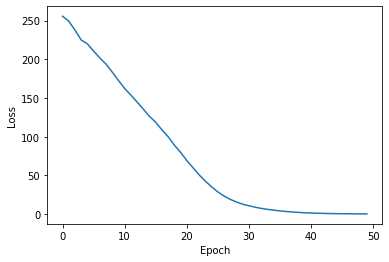

In [25]:
# Random seed for reproducible experiments
torch.manual_seed(0)

# Load data
data_matrix = read_data('examples_all.txt', 'data_all.txt')
train_data, val_data = random_split(data_matrix, [25, 223])

# Includes things like # of epochs, etc.
params = {
    'num_epochs' : 50,
    'embedding' : bert_embedding
}

model = NeuralNetwork(hidden_size = 50)

# Choice of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

train_and_evaluate(model, train_data, val_data, optimizer, loss_function, params, idx_to_word)

In [19]:
def train_and_evaluate(model, train_data, val_data, optimizer, loss_function, params, idx_to_word): 
    epochs = params['num_epochs']
    embedding = params['embedding']
    
    embedding_pt = torch.tensor(embedding, requires_grad=False)
    V, K = embedding.shape
    
    all_loss = []
    
    for epoch in range(epochs): 
        print('Epoch: {}'.format(epoch))
        
        # Set model to train
        model.train()
        
        # Initialize loss
        loss = 0
        
        for example in train_data:
            board, gold_word = example
            
            board_pt = torch.tensor(board, requires_grad=False)
            gold_word_pt = torch.tensor(gold_word, requires_grad=False)
    
            board_embedding_pt = embedding_pt[board_pt].view(1, 2 * K) # 2 x 768
            board_embedding_big = board_embedding_pt.expand(V, 2 * K) # V x (2 X 768)
            
            # Add embedding for each vocab word to board_embedding_big
            all_input = torch.cat([embedding_pt, board_embedding_big], dim=1) # (V x 1536)
            
            output = model(all_input)
            output_T = torch.transpose(output, 0, 1)
            
            loss += loss_function(output_T, gold_word_pt)
        
        all_loss.append(loss)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Backprop
        loss.backward()
        
        # Perform update using 
        optimizer.step()
        
        val_acc = evaluate(model, val_data, loss_function, params, idx_to_word)
        train_acc = evaluate(model, train_data, loss_function, params, idx_to_word)
        print('For epoch', epoch, 'training accuracy is', train_acc, 'and test accuracy is', val_acc)
    
    plt.plot(all_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    